# RAG over complex Documents


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-west-2.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-5-Sonnet': 'anthropic.claude-3-5-sonnet-20240620-v1:0',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Opus': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'T

## 2. Titan Embedding 및 LLM 인 Claude-v3.5-sonnet 모델 로딩

### LLM 로딩 (Claude-v3.5-sonnet)

In [5]:
from langchain_aws import ChatBedrock
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = ChatBedrock(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-5-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

ChatBedrock(callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f5e20207dc0>], client=<botocore.client.BedrockRuntime object at 0x7f5dfb7be650>, model_id='anthropic.claude-3-5-sonnet-20240620-v1:0', model_kwargs={'stop_sequences': ['\n\nHuman']}, streaming=True, max_tokens=1024)

### Embedding 모델 선택

In [7]:
from langchain_aws import BedrockEmbeddings

In [8]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Text-Embeddings-V2")
)
dimension = 1024 #1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed)

In [9]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [10]:
depoly = True

In [11]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

---------!

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Accept: ('application/json',)
ContentType: application/json
Endpoint: huggingface-pytorch-inference-2024-10-16-03-33-44-209


#### Save reranker endpoint to Parameter Store

In [12]:
if depoly:

    import boto3
    from utils.ssm import parameter_store

    region=boto3.Session().region_name
    pm = parameter_store(region)

    pm.put_params(
        key="reranker_endpoint",
        value=f'{predictor.endpoint}',
        overwrite=True,
        enc=False
    )

The endpoint attribute has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Parameter stored successfully.


## 4. Invocation (prediction)

In [13]:
from utils.ssm import parameter_store

In [14]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [15]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7f5dd37356c0>


In [16]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [17]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [18]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "나는 너를 사랑하지 않아", "text_pair": "나는 너를 좋아하지 않아"},
            {"text": "그는 너를 싫어해", "text_pair": "그는 너를 좋아해"}
        ]
    }
)

In [19]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.9984032511711121}, {'label': 'LABEL_0', 'score': 0.004707992542535067}]
CPU times: user 14.3 ms, sys: 0 ns, total: 14.3 ms
Wall time: 664 ms


## 5. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [20]:
import boto3
from utils.ssm import parameter_store

In [21]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [22]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [23]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [24]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: complex-doc-index


### OpenSearch Client 생성

In [25]:
from utils.opensearch import opensearch_utils

In [26]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [27]:
from utils.rag import rag_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [28]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    hybrid_search_debugger="None", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=False, # enable parent document
    
    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]

    #rag_fusion=True, # enable rag_fusion
    #query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=False, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

### QA chain 정의

In [29]:
from textwrap import dedent

In [30]:
system_prompt = dedent(
    """
    You are a master answer bot designed to answer user's questions.
    I'm going to give you contexts which consist of texts, tables and images.
    Read the contexts carefully, because I'm going to ask you a question about it.
    """
)

human_prompt = dedent(
    """
    Here is the contexts as texts: <contexts>{contexts}</contexts>

    First, find a few paragraphs or sentences from the contexts that are most relevant to answering the question.
    Then, answer the question as much as you can.

    Skip the preamble and go straight into the answer.
    Don't insert any XML tag such as <contexts> and </contexts> when answering.
    Answer in Korean.

    Here is the question: <question>{question}</question>

    If the question cannot be answered by the contexts, say "No relevant contexts".
    """
)

In [31]:
qa = rag_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    human_prompt=human_prompt,
    return_context=True,
    verbose=False,
    #multi_turn=True
)

In [44]:
#query = "중지된 경우 이체"
query = "부정청탁 제제"

response, contexts = qa.invoke(
    query = query
)

verbose False
부정청탁에 대한 제재는 다음과 같습니다:

1. 부정 청탁을 한 자에 대해 2년 이하의 징역 또는 3천만 원 이하의 과태료가 부과됩니다.

2. 청탁 유형별로 별도의 제재 기준이 적용됩니다.

3. 누구든지 직무를 수행하는 공직자 등에게 직접 또는 제삼자를 통한 부정 청탁을 하는 것이 금지됩니다.

4. 법에 열거된 14가지 대상 직무에 관하여 법령을 위반하거나 지위·권한을 남용하게 하는 행위가 부정 청탁에 해당합니다.

5. 공직자 등이 부정 청탁을 받고 그에 따라 직무를 수행한 경우에도 처벌 대상이 됩니다.

이러한 제재는 청탁금지법에 따라 공직자의 공정한 직무수행을 보장하고 공공기관에 대한 국민의 신뢰를 확보하기 위해 시행되고 있습니다.


-----------------------------------------------
1. Category: Table, Chunk: 366 Characters
-----------------------------------------------


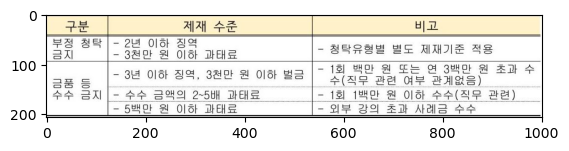

이 표는 부정청탁 및 금품 등 수수의 금지에 관한 법률(일명 '김영란법')의 주요 제재 내용을 요약하고 있습니다.

주요 내용은 다음과 같습니다:

1. 부정 청탁 금지: 2년 이하 징역 또는 3천만 원 이하 과태료
2. 금품 등 수수 금지:
   - 3년 이하 징역, 3천만 원 이하 벌금 (1회 100만원 또는 연 300만원 초과 수수 시)
   - 수수 금액의 2~5배 과태료 (1회 100만원 이하 직무 관련 수수 시)
   - 5백만 원 이하 과태료 (외부 강의 초과 사례금 수수 시)

이 법은 공직자 등의 부패를 방지하고 공정한 직무수행을 보장하기 위해 제정되었으며, 위반 행위의 종류와 정도에 따라 다양한 수준의 제재를 규정하고 있습니다.


metadata:
 {'origin_table': '| 구분 | 제재 수준 | 비고 |\n| --- | --- | --- |\n| 부정 청탁 금지 | - 2년 이하 징역 - 3천만 원 이하 과태료
| - 청탁유형별 별도 제재기준 적용 |\n| 금품 등 수수 금지 | - 3년 이하 징역, 3천만 원 이하 벌금 | - 1회 백만 원 또는 연 3백만 원 초과 수 수(직무 관련
여부 관계없음) |\n| 금품 등 수수 금지 | - 수수 금액의 2~5배 과태료 | - 1회 1백만 원 이하 수수(직무 관련) |\n| 금품 등 수수 금지 | - 5백만 원 이하
과태료 | - 외부 강의 초과 사례금 수수 |\n', 'text_as_html': '| 구분 | 제재 수준 | 비고 |\n| --- | --- | --- |\n| 부정 청탁 금지
| - 2년 이하 징역 - 3천만 원 이하 과태료 | - 청탁유형별 별도 제재기준 적용 |\n| 금품 등 수수 금지 | - 3년 이하 징역, 3천만 원 이하 벌금 | - 1회 백만
원 또는 연 3백만 원 초과 수 수(직무 관련 여부 관계없음) |\n| 금품 등 수수 금지 | - 수수 금액의 2~5배 과태료 | - 1회 1백만 원 이하 수수(직무 관련)
|\n| 금품 등 수수 금지 | - 5백만 원 이하 과태료 | - 외부 강의 초과 사례금 수수 |\n', 'category': 'Table', 'image_base64': '',
'family_tree': 'parent_table', 'parent_id': 'NA', 'id': '89130166-3acf-4e0e-9067-7a34365e9d4e',
'origin_image': '', 'orig_elements': ''}

-----------------------------------------------
2. Chunk: 1012 Characters
-----------------------------------------------
2. 부정 청탁의 금지(제5조)

○ 누구든지 직무를 수행하

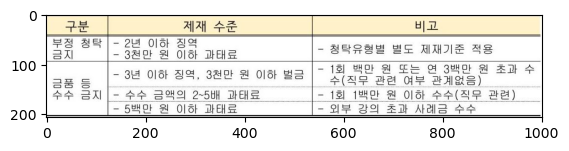

다음과 같이 요청하신 정보를 제공해 드리겠습니다:

<title>청탁금지법 관련 금품 등 수수 제한 규정</title>

<summary>
이 표는 청탁금지법에 따른 금품 등 수수 제한에 대한 상세 규정을 보여줍니다. 부정 청탁 금지, 금품 등 수수 금지, 외부 강의 사례금 수수 제한에 대한 구체적인 금액과 조건을
명시하고 있습니다. 각 항목별로 적용 기간, 금액 한도, 그리고 특별 고려사항 등이 자세히 기술되어 있습니다.
</summary>

<entities>
1. 부정 청탁 금지: 2년 이하 징역 또는 3천만 원 이하 과태료 부과
2. 금품 등 수수 금지: 3년 이하 징역 또는 3천만 원 이하 벌금, 수수 금액의 2-5배 과태료 부과, 5백만 원 이하 과태료 부과 등 위반 정도에 따라 다양한 처벌 적용
3. 외부 강의 사례금: 1회 백만 원 또는 연 3백만 원 초과 수령 시 신고 의무, 1회 1백만 원 이하 수수 시 직무 관련성 고려, 외부 강의 초과 사례금 수수 금지
</entities>

<hypothetical_questions>
1. 공직자가 직무와 관련하여 1회 80만 원 상당의 선물을 받았다면 어떤 처벌을 받게 되나요?
2. 외부 강의 사례금으로 1회에 150만 원을 받은 경우, 어떤 절차를 따라야 하나요?
3. 3년 동안 동일인으로부터 총 350만 원 상당의 금품을 여러 차례에 걸쳐 받은 경우, 청탁금지법 위반에 해당하나요?
4. 부정 청탁을 한 사람과 이를 받아들인 공직자는 각각 어떤 처벌을 받게 되나요?
</hypothetical_questions>
metadata:
 {'markdown': '| 구분 | 제재 수준 | 비고 |\n| --- | --- | --- |\n| 부정 청탁 금지 | - 2년 이하 징역 - 3천만 원 이하 과태료 | -
청탁유형별 별도 제재기준 적용 |\n| 금품 등 수수 금지 | - 3년 이하 징역, 3천만 원 이하 벌금 | - 1회 백만 원 또는 연 3백만 원 초과 수 수(직무 관련 여부
관계없음) |\n| 금품

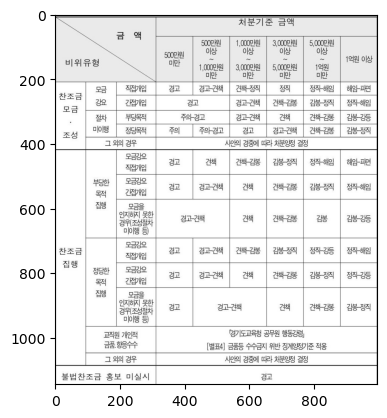

이 표는 불법 찬조금과 관련된 처분 기준을 상세히 나타내고 있습니다. 주요 내용은 다음과 같습니다:

1. 찬조금 모금·조성, 집행, 홍보 미실시 등의 유형별로 구분되어 있습니다.
2. 처분 기준 금액에 따라 500만원 미만부터 1억원 이상까지 6단계로 나누어져 있습니다.
3. 각 유형과 금액대별로 주의, 경고, 견책, 감봉, 정직, 강등, 해임, 파면 등의 처분이 정해져 있습니다.
4. 모금 강요의 직접/간접 개입, 절차 미이행, 부당/정당 목적 등에 따라 처분 수위가 달라집니다.
5. 교직원의 개인적 금품·향응 수수는 별도의 징계양정기준을 적용합니다.
6. 대부분의 경우 금액이 높아질수록 처분 수위도 높아지는 경향을 보입니다.
7. 일부 항목은 "사안의 경중에 따라 처분양정 결정"으로 되어 있어 상황에 따른 유연한 적용이 가능합니다.

이 표는 교육 기관에서 불법 찬조금 관련 문제 발생 시 처리 기준을 제시하고 있습니다.


metadata:
 {'origin_table': '|  | 처분기준 금액 | 처분기준 금액 | 처분기준 금액 | 처분기준 금액 | 처분기준 금액 | 처분기준 금액 |  |  |\n| --- |
--- | --- | --- | --- | --- | --- | --- | --- |\n| 금 액 비위유형 | 금 액 비위유형 | 금 액 비위유형 | 500만원 미만 | 500만원
이상 ～ 1,000만원 미만 | 1,000만원 이상 ～ 3,000만원 미만 | 3,000만원 이상 ～ 5,000만원 미만 | 5,000만원 이상 ～ 1억원 미만 | 1억원 이상
|\n| 찬조금 모금 ․ 조 성 | 모금 강요 | 직접개입 | 경고 | 경고-견책 | 견책-정직 | 정직 | 정직-해임 | 해임-파면 |\n| 찬조금 모금 ․ 조 성 | 모금 강요
| 간접개입 | 경고 | 경고 | 경고-견책 | 견책-감봉 | 감봉-정직 | 정직-해임 |\n| 찬조금 모금 ․ 조 성 | 절차 미이행 | 부당목적 | 주의-경고 | 주의-경고 |
경고-견책 | 견책 | 견책-감봉 | 감봉-강등 |\n| 찬조금 모금 ․ 조 성 | 절차 미이행 | 정당목적 | 주의 | 주의-경고 | 경고 | 경고-견책 | 견책-감봉 | 감봉-
정직 |\n| 찬조금 모금 ․ 조 성 | 그 외의 경우 | 그 외의 경우 | 사안의 경중에 따라 처분양정 결정 | 사안의 경중에 따라 처분양정 결정 | 사안의 경중에 따라 처분양정
결정 | 사안의 경중에 따라 처분양정 결정 | 사안의 경중에 따라 처분양정 결정 | 사안의 경중에 따라 처분양정 결정 |\n| 찬조금 집행 | 부당한 목적 집행 | 모금강요
직접개입 | 경고 | 견책 | 견책-감봉 | 감봉-정직 | 정직-해임 | 해임-파면 |\n| 찬조금 집행 | 부당한 목적 집행 | 모금강요 간접개입 | 경고 | 경고-견책 | 견책
| 견책-감봉 | 감봉-정직 | 정직-해임 |\n| 찬조금 집행 | 부당한 목적 집행 | 모금을 인지하지 못한 경우(조성절차 미이행 등) | 경고-견책 | 경고

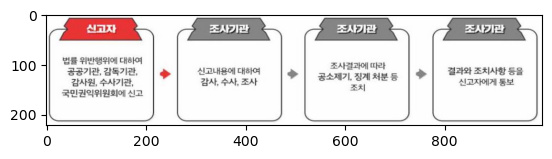

<title>청탁금지법</title>

<summary>
이 이미지는 청탁금지법의 신고 처리 과정을 단계별로 보여주는 도식입니다. 신고자, 조사기관, 그리고 결과 처리의 세 단계로 구성되어 있습니다. 각 단계에서 수행되는 주요 활동들이
간략하게 기술되어 있습니다.
</summary>

<entities>
1. 신고자: 법률 위반행위에 대하여 공공기관, 감독기관, 감사원, 수사기관, 국민권익위원회에 신고하는 주체입니다.
2. 조사기관: 신고 내용에 대하여 감사, 수사, 조사를 실시하는 기관입니다.
3. 조사결과: 조사 과정을 거친 후 공소제기, 징계 처분 등 조치가 이루어집니다.
4. 결과 통보: 최종 조사 결과와 조치사항 등을 신고자에게 알리는 단계입니다.
</entities>

<hypothetical_questions>
1. 청탁금지법 위반 사항을 어떤 기관에 신고할 수 있나요?
2. 신고 접수 후 조사기관에서는 어떤 절차를 거치나요?
3. 조사결과에 따라 어떤 조치들이 취해질 수 있나요?
4. 신고자는 조사 결과를 어떻게 알 수 있나요?
5. 청탁금지법 위반 신고 처리 과정에서 신고자의 보호는 어떻게 이루어지나요?
</hypothetical_questions>
metadata:
 {'markdown': '', 'category': 'Image', 'image_base64': '', 'family_tree': 'parent_image',
'parent_id': 'NA', 'id': 'fe564aef-d112-470c-865f-f69c469a35dd', 'origin_image': '',
'orig_elements': ''}


In [45]:
show_context_used(contexts)

In [40]:
system_prompt = prompt_repo.get_system_prompt()

In [36]:
qa = rag_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)

디지털 성범죄는 다음과 같이 정의됩니다:

디지털 기기, 정보통신망을 매개로 제작, 배포, 유통되는 형식의 범죄입니다. 구체적으로는 개인의 나체사진이나 성행위 영상, 몰래카메라 제작물 등을 사이버 공간에서 불특정 다수에게 전달하는 행위를 포함합니다.

디지털 성범죄는 크게 세 가지 유형으로 구분됩니다:
1. 유포형
2. 참여형
3. 소비형

이러한 범죄는 타인의 사생활을 침해하고 정신적 피해를 줄 수 있는 심각한 문제입니다. 따라서 사이버 공간에서도 실제 현실과 같은 윤리의식을 가지고 행동해야 하며, 타인의 개인정보를 무단으로 공유하거나 게시하는 행위를 삼가야 합니다.
-----------------------------------------------
1. Category: Image, Chunk: 138 Characters
-----------------------------------------------


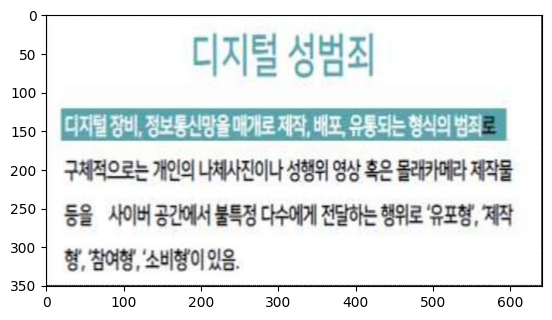

이미지는 '디지털 성범죄'에 대한 설명입니다. 디지털 성범죄는 디지털 기기나 정보통신망을 이용하여 불법적인 촬영물이나 영상을 유포하는 범죄라고 설명하고 있습니다. 이러한 범죄를
'유포형', '저장형', '소비형' 등으로 구분하여 설명하고 있습니다.
metadata:
 {'img_path': './fig/figure-16-28.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '9514f72f-4aaa-4199-b8bc-2d1e8d8639a0', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Category: Image, Chunk: 244 Characters
-----------------------------------------------


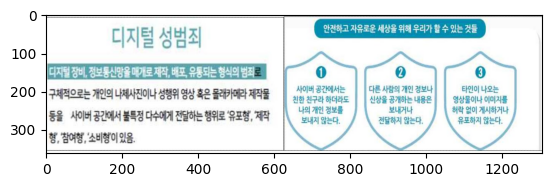

이 이미지는 디지털 성범죄에 대한 정보를 제공하고 있습니다. 왼쪽에는 디지털 성범죄의 정의와 문제점이 설명되어 있고, 오른쪽에는 안전한 자유로운 세상을 위해 우리가 할 수 있는
행동 3가지가 제시되어 있습니다. 1) 사이버 공간에서는 실제 현실과 같다는 인식을 가져야 한다. 2) 타인의 사생활 보호를 위해 개인정보를 무단 공유하지 말아야 한다. 3)
디지털 성범죄 예방을 위해 올바른 정보를 유포하고 인식을 개선해야 한다는 내용입니다.
metadata:
 {'img_path': './fig/figure-3-20.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '4408ecf5-a630-4cdf-adc0-cb84bdbf09e6', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
3. Category: CompositeElement, Chunk: 825 Characters
-----------------------------------------------
. ③ 부부간에 존중하고 사랑하는 모습을 자녀 앞에서 자연스럽게 표현하도록 합니다. ④ 질문에 답할 때는 당황하거나 회피하지 말고 불충분한 대답이라도 좋으나 거짓말은 하지 말아야
합니다. - 성에 관한 설명은 구체적, 직접적으로 표현해야 합니다. 그 질문을 왜 했는지 알아보세요. ⑤ 성교육은 과학적인 면과 사회적, 윤리적인 면을 병행하여 가르쳐야 합니다.
⑥ 부모가 해결하기 어려운 문제는 전문교사나 상담기관을 찾습니다. 8. 디지털 성범죄 예방 디지터 서버시 안 전 하 고 자 유 로 운 세 상 을 위해 우 리 가 할 수 있 는 것
들 = OH™ 디 지 털 장 비 , 정 보 통 신 망 올 매 개 로 제삭 배포 유 통 되 는 형 식 의 범 죄 0 2} 8 사 이버 공 간 

In [37]:
query = "디지털 성범죄란?"

response, contexts = qa.invoke(
    query=query,
    verbose=False
)

show_context_used(contexts)

### Parameter updates

In [ ]:
opensearch_hybrid_retriever.update_search_params(
    k=7,
    minimum_should_match=0,
    
    # hybird-search debugger
    hybrid_search_debugger="None", #[lexical, semantic, None]
    
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    
    rag_fusion=False, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    
    hyde=False, # enable hyde
    hyde_query=["web_search"], # query type in hyde 
    
    parent_document=False, # enable parent document
    
    # option for complex documents consisting of text, table and image
    complex_doc=True, # False 이면, invocation시 text만 넣는다. 단, 
    
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [ ]:
query = "여름철 폭염 검강관리 3대 수칙은?" # for table

In [ ]:
response, contexts = qa.invoke(
    query = query,
    verbose=False
)

In [ ]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)

### Multi-turn using chat history

In [ ]:
from utils.chat import chat_utils
from langchain.schema.output_parser import StrOutputParser
from langchain_core.prompts import MessagesPlaceholder
from langchain_core.prompts import ChatPromptTemplate, HumanMessagePromptTemplate, SystemMessagePromptTemplate

#### Momory setting and Save query and response as chat history

In [ ]:
memory = chat_utils.get_memory(
    memory_type="ConversationBufferMemory",
    memory_key="chat_history"
)

history = memory.load_memory_variables({})["chat_history"]

In [ ]:
memory.chat_memory.add_user_message(query)
memory.chat_memory.add_ai_message(response)

In [ ]:
print('memory: ', history)

#### Rephrase quetions based on chat hostory 

In [4]:
human_prompt = """
               Here is the question: <question>{question}</question>
               Write in Korean.
               """
               
system_prompt = prompt_repo.get_contextualize_system_prompt()
system_message_template = SystemMessagePromptTemplate.from_template(system_prompt)
human_message_template = HumanMessagePromptTemplate.from_template(human_prompt)

NameError: name 'prompt_repo' is not defined

In [ ]:
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        system_message_template,
        MessagesPlaceholder("chat_history"),
        human_message_template
    ]
)

In [ ]:
chain = contextualize_q_prompt | llm_text | StrOutputParser()

In [ ]:
#query = "첫 번째 답에서 각 사례, 유형은 뭐가 있어?"
query = "학교에서 발생할 수 있는 감염병의 종류와 감염경로?"

history = memory.load_memory_variables({})["chat_history"]
print('memory: ', history)
revised_question = chain.invoke(
    {
        "chat_history": history,
        "question": query,
    }
)
revised_question = revised_question.replace("<result>", "").replace("</result>", "")
print ("=============")
print (f'revised_question: {revised_question}')

In [ ]:
print (f'revised_question: {revised_question}')

#### Repeat QA and save chat history

In [ ]:
response, contexts = qa.invoke(
    query = revised_question,
    verbose=False
)

In [ ]:
memory.chat_memory.add_user_message(query)
memory.chat_memory.add_ai_message(response)

In [ ]:
print('memory: ', history)